In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.utils import cross_group_predict
from pptoolbox.platform.automl_v4.loss_functions import *
from pptoolbox.platform.automl_v4.stop_functions import stopping_criteria

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

from skmultilearn.model_selection import iterative_train_test_split

import warnings
warnings.simplefilter("ignore")

import pickle as pkl
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# MLFLOW_TRACKING_URI = "http://127.0.0.1:8080" # "sqlite:///mlflow.db"

# import data

In [3]:
datasets = {
    'full': {},
    'nondeo': {}
}

pulldate = "250218"

In [4]:
datafolder_path = Path ("../data/processed")

# lots should be cleaned and preprocessed

for dataset in datasets:

    cleaned_input = pd.read_csv(datafolder_path / f"cleaned_input_{dataset}_{pulldate}.csv", index_col=0)

    cleaned_label = pd.read_csv(datafolder_path / f"cleaned_label_{dataset}_{pulldate}.csv", index_col=0)

    datasets[dataset]['cleaned_input'] = cleaned_input
    datasets[dataset]['cleaned_label'] = cleaned_label

    print(f"Dataset: {dataset} has {cleaned_input.shape} spectra and {cleaned_label.shape} label")

Dataset: full has (3787, 191) spectra and (3787, 20) label
Dataset: nondeo has (2549, 191) spectra and (2549, 19) label


In [42]:
datasets['full']['cleaned_input'].index.nunique()

748

# train test split random

In [ ]:
# # random split
# def train_test_split_lot_level (label_df, test_size=0.1):
#     label = label_df.set_index('lot_id')
#     sorted_idx = label.index.unique()
#     train_label, test_label = train_test_split(label.loc[sorted_idx], 
#                                                  test_size=test_size, 
#                                                  stratify=label.loc[sorted_idx]['ABOVE_BELOW_5pct_Dwarf'],
#                                                  shuffle=True, 
#                                                  random_state=42)
    
#     train_idx = train_label.index.sort_values()
#     test_idx = test_label.index.sort_values()

#     return train_idx, test_idx

# train_index, test_index = train_test_split_lot_level(label_df)
# print(train_index, test_index)

# #is test_idx in train_idx
# print(f'Is test index subset of train index? {set(test_index).issubset(set(train_index))}')


# train-test split multilabel stratify random

In [44]:
for dataset in datasets:
    
    print(f'\nProcessing {dataset} dataset')
    cleaned_input = datasets[dataset]['cleaned_label']

    cleaned_input = cleaned_input.reset_index().drop_duplicates(subset='lot_id').set_index('lot_id')

    # Convert DataFrame to NumPy array
    label_df_encoded = cleaned_input.copy(deep=True)

    X = label_df_encoded.index.values.reshape(-1, 1)

    encoder = LabelEncoder()

    for col in label_df_encoded.columns:
        label_df_encoded[col] = encoder.fit_transform(label_df_encoded[col])
    y = label_df_encoded.values  # Multi-label binary targets

    # Split dataset into train and test sets
    X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)

    train_idx = X_train.flatten()
    test_idx = X_test.flatten()

    datasets[dataset]['train_idx'] = train_idx
    datasets[dataset]['test_idx'] = test_idx

    print(X.shape, train_idx.shape, test_idx.shape)
    print(f'train and test is disjoint: {set(train_idx).isdisjoint(set(test_idx))}')



Processing full dataset
(748, 1) (597,) (151,)
train and test is disjoint: True

Processing nondeo dataset
(502, 1) (394,) (108,)
train and test is disjoint: True


# split by time

In [ ]:
# # train index is where replicate is not s2, test index is where replicate is s2
# label_df_temp = label_df.copy()
# label_df_temp = label_df_temp.set_index('lot_id')
# # train_index = label_df_temp[label_df_temp['replicate']!='s2'].index
# train_index = label_df_temp[~label_df_temp['replicate'].str.contains('s')].index
# test_index = label_df_temp[label_df_temp['replicate'].str.contains('s')].index

# print(train_index, "\n",test_index)

# #is test_idx in train_idx
# print(f'Is test index subset of train index? {set(test_index).issubset(set(train_index))}')


# visualise splits

In [47]:
for dataset in datasets:
    cleaned_label_copy = datasets[dataset]['cleaned_label'].copy(deep=True)
    cleaned_label_copy["train_test"] = np.where(cleaned_label_copy.index.isin(datasets[dataset]['train_idx']), 'train', 'test')
    datasets[dataset]['cleaned_label_split'] = cleaned_label_copy.drop_duplicates()

full dataset:


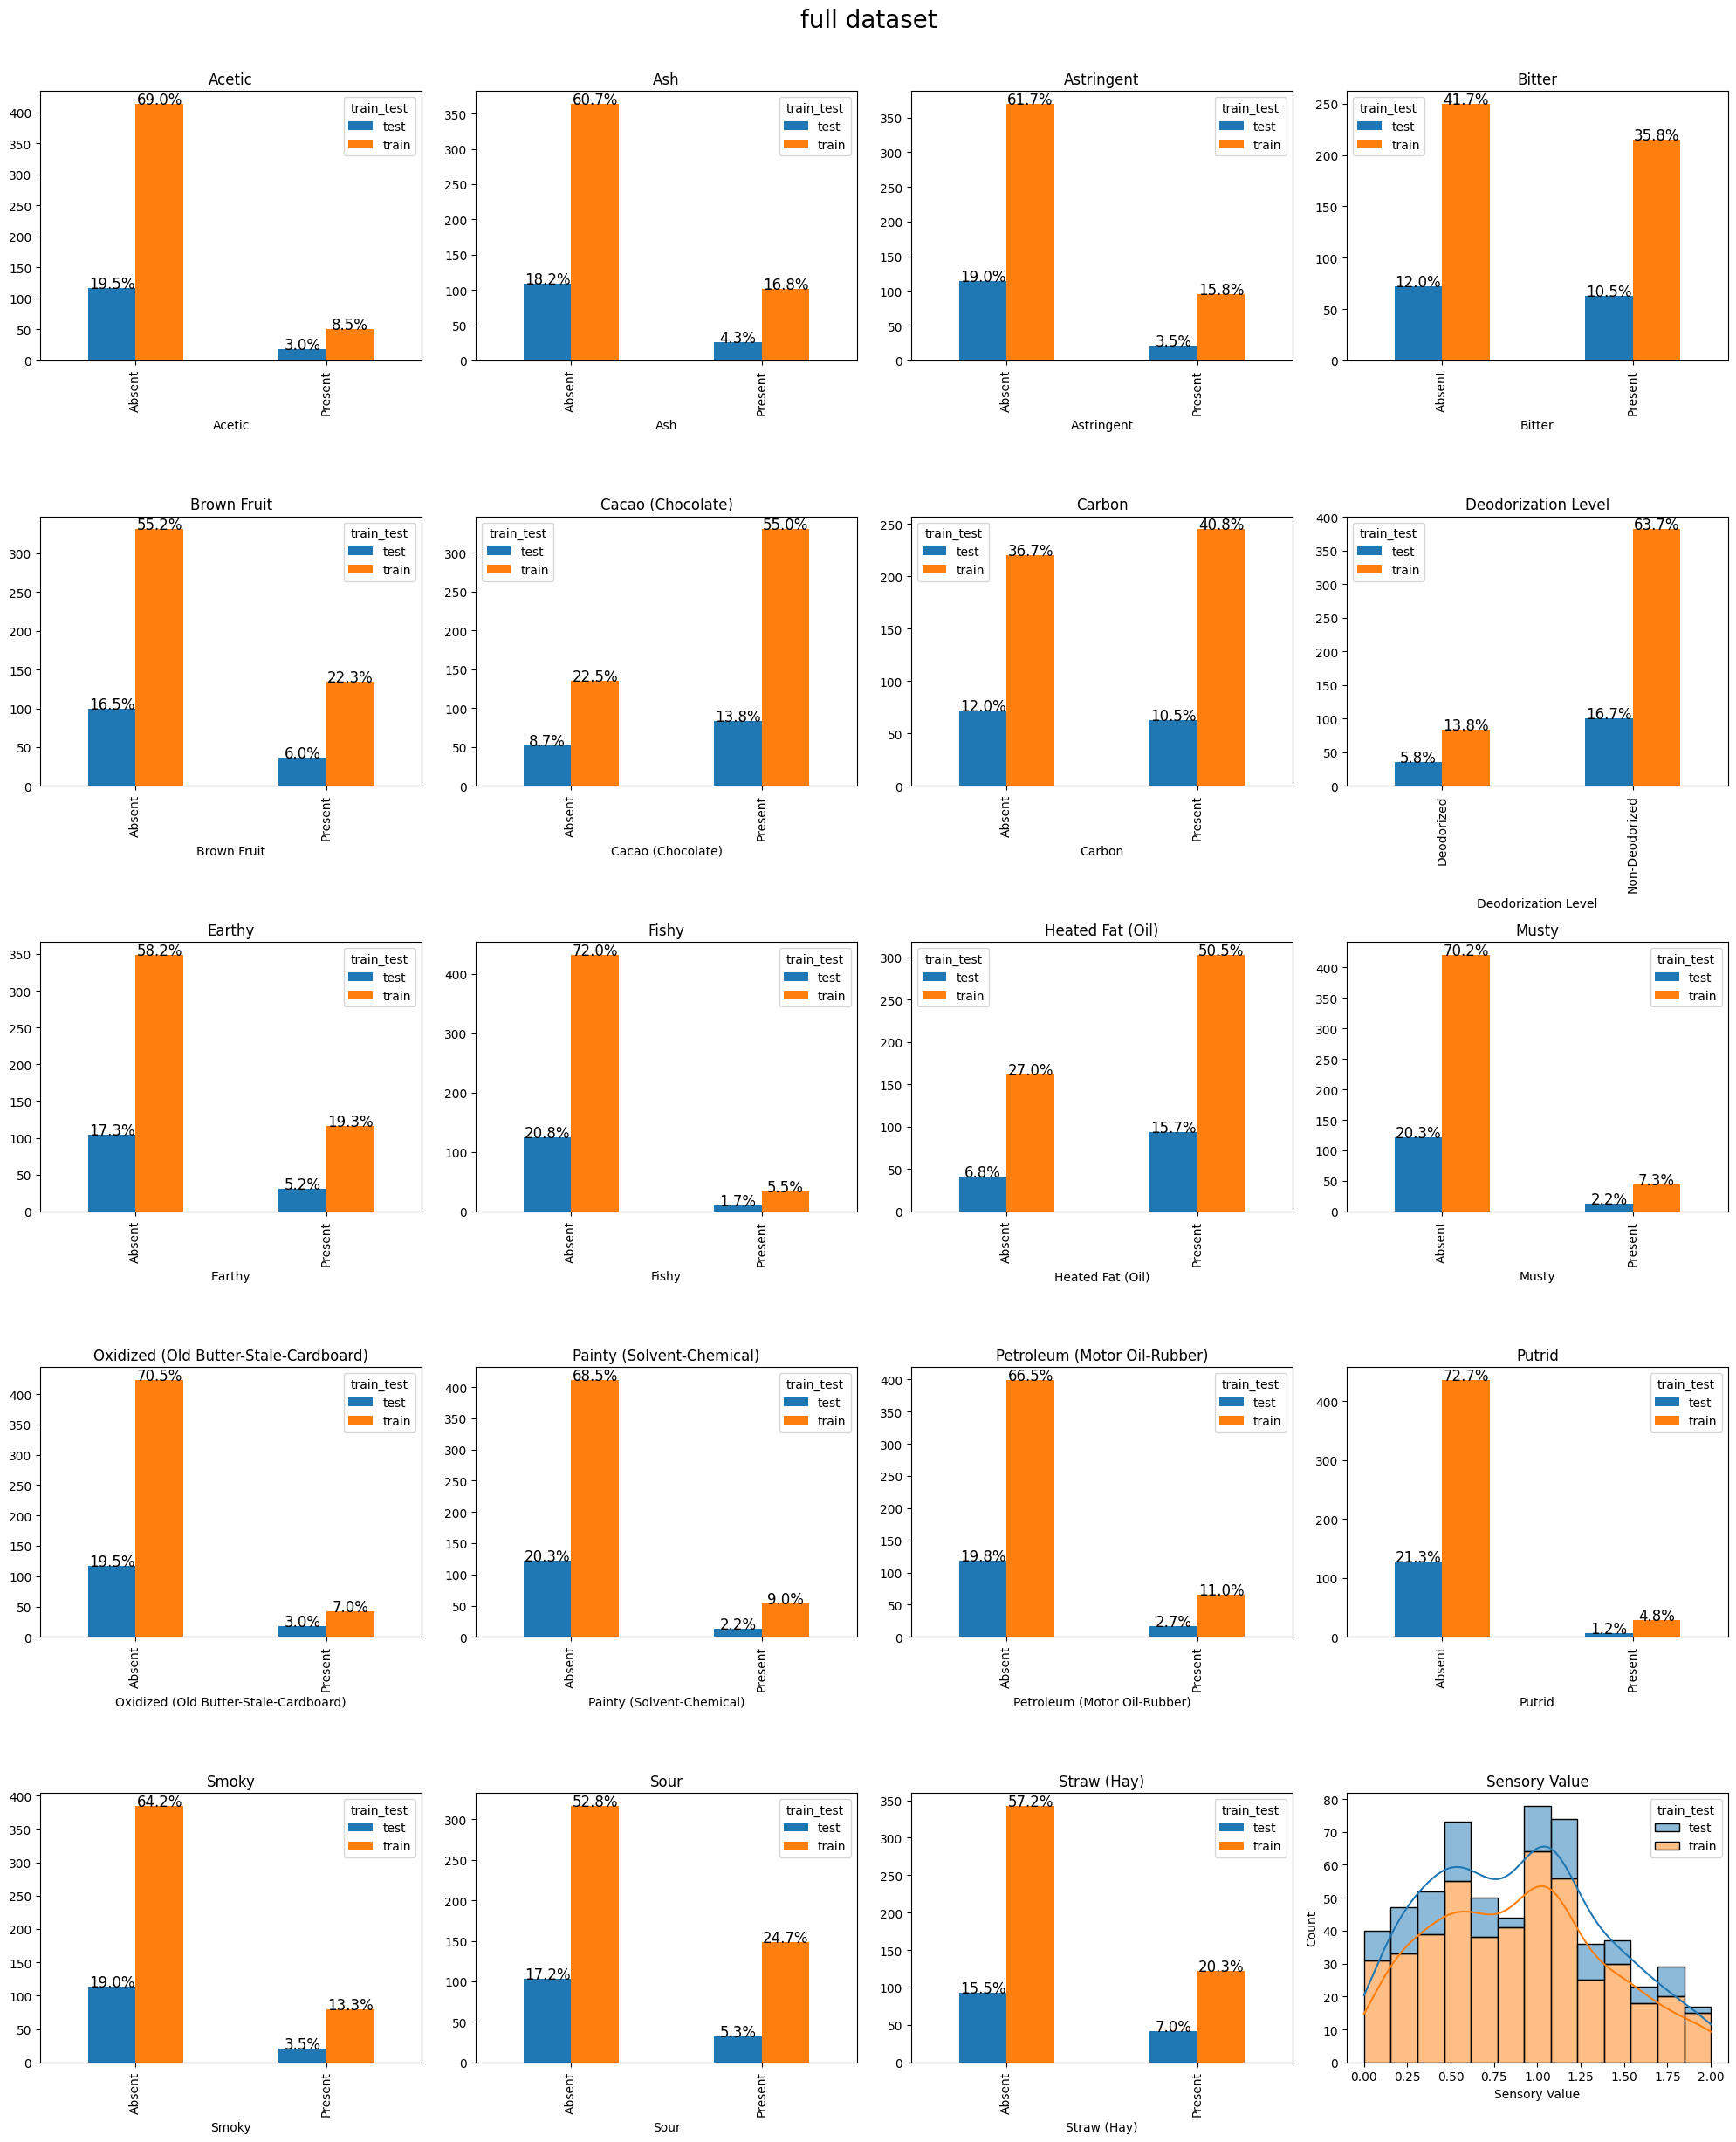

nondeo dataset:


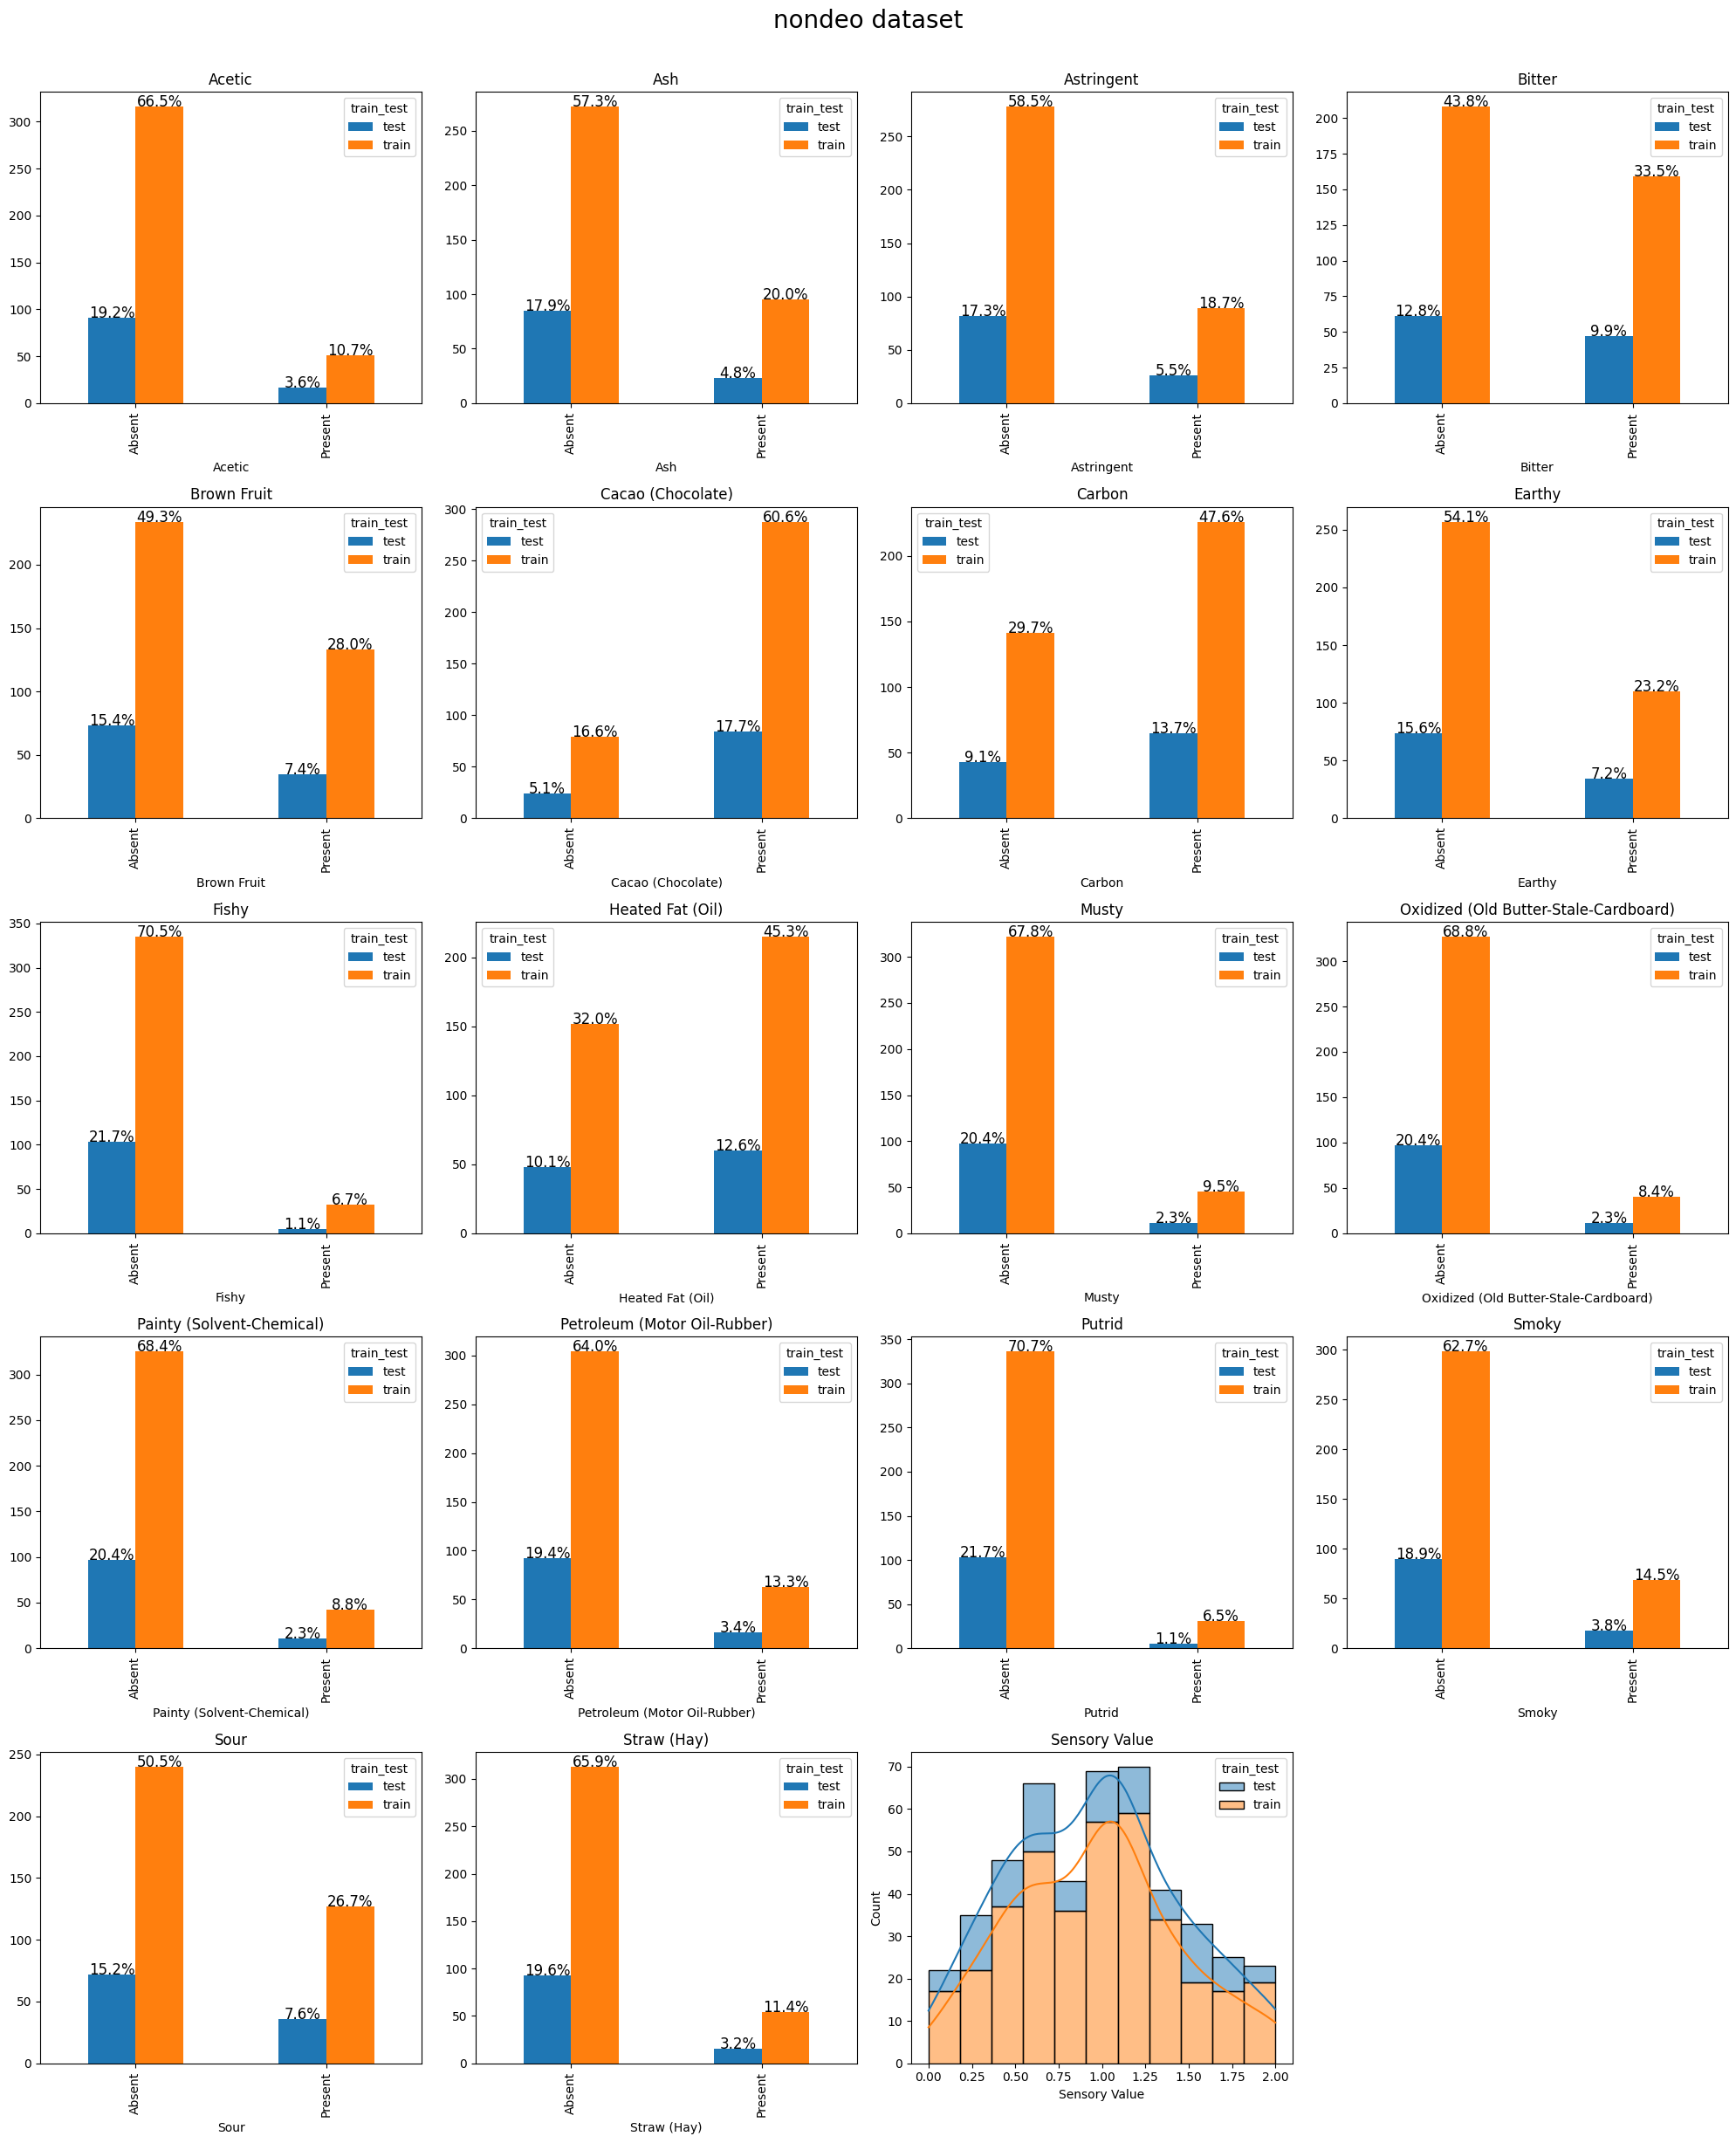

In [48]:
for dataset in datasets:
    cleaned_label_copy = datasets[dataset]['cleaned_label_split'].sort_values(by=['train_test'])
    print(f'{dataset} dataset:')

    num_cols = len(cleaned_label_copy.columns) - 1  # Exclude 'train_test'
    rows = int(np.ceil(num_cols / 4))  # Calculate required rows dynamically
    fig, ax = plt.subplots(rows, 4, figsize=(20, 5 * rows))
    fig.suptitle(f'{dataset} dataset\n\n', fontsize=20)

    # Flatten ax to avoid indexing issues when rows < 4
    ax = ax.flatten()

    for i, col in enumerate(cleaned_label_copy.drop(columns=['train_test']).columns):
        
        if cleaned_label_copy[col].dtype == 'float64':
            sns.histplot(data=cleaned_label_copy, x=col, hue='train_test', ax=ax[i], kde=True, multiple='stack')
            ax[i].set_title(f'{col}')
        else:
            value_counts = cleaned_label_copy.groupby([col, 'train_test']).size().unstack(fill_value=0)
            total = value_counts.sum().sum()  # Get total count for percentage
            value_counts.plot(kind='bar', stacked=False, ax=ax[i])
            ax[i].set_title(f'{col}')
            
            # Add percentage labels
            for p in ax[i].patches:
                height = p.get_height()
                if height > 0:
                    ax[i].text(
                        p.get_x() + p.get_width() / 2.,
                        height,
                        f'{(height / total) * 100:.1f}%',
                        ha='center',
                        fontsize=12,
                        color='black'
                    )

    # Hide any unused subplots
    for j in range(i+1, len(ax)):
        fig.delaxes(ax[j])

    plt.tight_layout()
    plt.show()


In [51]:
for dataset in datasets:
    print(f'\nProcessing {dataset} dataset')
    save_dir = f"../data/processed/{dataset}"
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    cleaned_input = datasets[dataset]['cleaned_input']
    cleaned_label = datasets[dataset]['cleaned_label']
    print(f'cleaned_input: {cleaned_input.shape}, cleaned_label: {cleaned_label.shape}')

    train_idx = datasets[dataset]['train_idx']
    test_idx = datasets[dataset]['test_idx']
    print(f'cleaned_label: {cleaned_label.reset_index().drop_duplicates().shape}, train_idx: {train_idx.shape}, test_idx: {test_idx.shape}')

    X_train = cleaned_input[cleaned_input.index.isin(train_idx)]
    X_test = cleaned_input[cleaned_input.index.isin(test_idx)]
    y_train = cleaned_label[cleaned_label.index.isin(train_idx)]
    y_test = cleaned_label[cleaned_label.index.isin(test_idx)]

    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

    X_train.to_csv(f'{save_dir}/Xtrain.csv')
    X_test.to_csv(f'{save_dir}/Xtest.csv')
    y_train.to_csv(f'{save_dir}/ytrain.csv')
    y_test.to_csv(f'{save_dir}/ytest.csv')

    datasets[dataset]['X_train'] = X_train
    datasets[dataset]['X_test'] = X_test
    datasets[dataset]['y_train'] = y_train
    datasets[dataset]['y_test'] = y_test

    # X_train = X_train.reset_index()
    # X_test = X_test.reset_index()
    # y_train = y_train.reset_index()
    # y_test = y_test.reset_index()


Processing full dataset
cleaned_input: (3787, 191), cleaned_label: (3787, 20)
cleaned_label: (748, 21), train_idx: (597,), test_idx: (151,)
X_train: (3024, 191), y_train: (3024, 20)
X_test: (763, 191), y_test: (763, 20)

Processing nondeo dataset
cleaned_input: (2549, 191), cleaned_label: (2549, 19)
cleaned_label: (502, 20), train_idx: (394,), test_idx: (108,)
X_train: (2004, 191), y_train: (2004, 19)
X_test: (545, 191), y_test: (545, 19)


# downsample manual

In [3]:
datasets = {
    'full': {},
    # 'deo': {},
    'nondeo': {}
}

In [ ]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')

    save_dir = f"../data/processed/{dataset}"

    X_train = pd.read_csv(f'{save_dir}/Xtrain.csv', index_col=0)
    X_test = pd.read_csv(f'{save_dir}/Xtest.csv', index_col=0)
    y_train = pd.read_csv(f'{save_dir}/ytrain.csv', index_col=0)
    y_test = pd.read_csv(f'{save_dir}/ytest.csv', index_col=0)

    datasets[dataset]['X_train'] = X_train
    datasets[dataset]['X_test'] = X_test
    datasets[dataset]['y_train'] = y_train
    datasets[dataset]['y_test'] = y_test

    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')
    print()

In [ ]:
def get_majority_class_idx(df):
    majority_class = df.select_dtypes(include=['object']).mode().iloc[0]
    majority_class_rows= df.select_dtypes(include=['object']).apply(lambda x: x != majority_class[x.name]).sum(axis=1) <= 5
    majority_class_indices = df[majority_class_rows].index.unique()
    return majority_class_indices

for dataset in datasets:
    print(f'Processing {dataset} dataset')

    X_train = datasets[dataset]['X_train']
    y_train = datasets[dataset]['y_train']

    majority_class_indices = get_majority_class_idx(y_train)
    print(f'Majority class indices: {len(majority_class_indices)}')

    X_train_downsampled = pd.DataFrame(X_train.drop(index=majority_class_indices))
    y_train_downsampled = y_train.drop(index=majority_class_indices)

    datasets[dataset]['X_train_downsampled'] = X_train_downsampled
    datasets[dataset]['y_train_downsampled'] = y_train_downsampled

    X_train_downsampled.to_csv(f'../data/processed/{dataset}/Xtrain_downsampled.csv')
    y_train_downsampled.to_csv(f'../data/processed/{dataset}/ytrain_downsampled.csv')

    print(X_train_downsampled.shape, y_train_downsampled.drop_duplicates().shape)

In [5]:
for dataset in datasets:

    print(f'Processing {dataset} dataset')

    save_dir = f"../data/processed/{dataset}"

    X_train_downsampled = pd.read_csv(f'{save_dir}/Xtrain_downsampled.csv', index_col=0)
    y_train_downsampled = pd.read_csv(f'{save_dir}/ytrain_downsampled.csv', index_col=0)

    datasets[dataset]['X_train_downsampled'] = X_train_downsampled
    datasets[dataset]['y_train_downsampled'] = y_train_downsampled

    print(f'X_train_downsampled: {X_train_downsampled.shape}, y_train_downsampled: {y_train_downsampled.shape}')
    print()

Processing full dataset
X_train_downsampled: (527, 191), y_train_downsampled: (527, 20)

Processing nondeo dataset
X_train_downsampled: (459, 191), y_train_downsampled: (459, 19)



Processing full dataset
Processing nondeo dataset


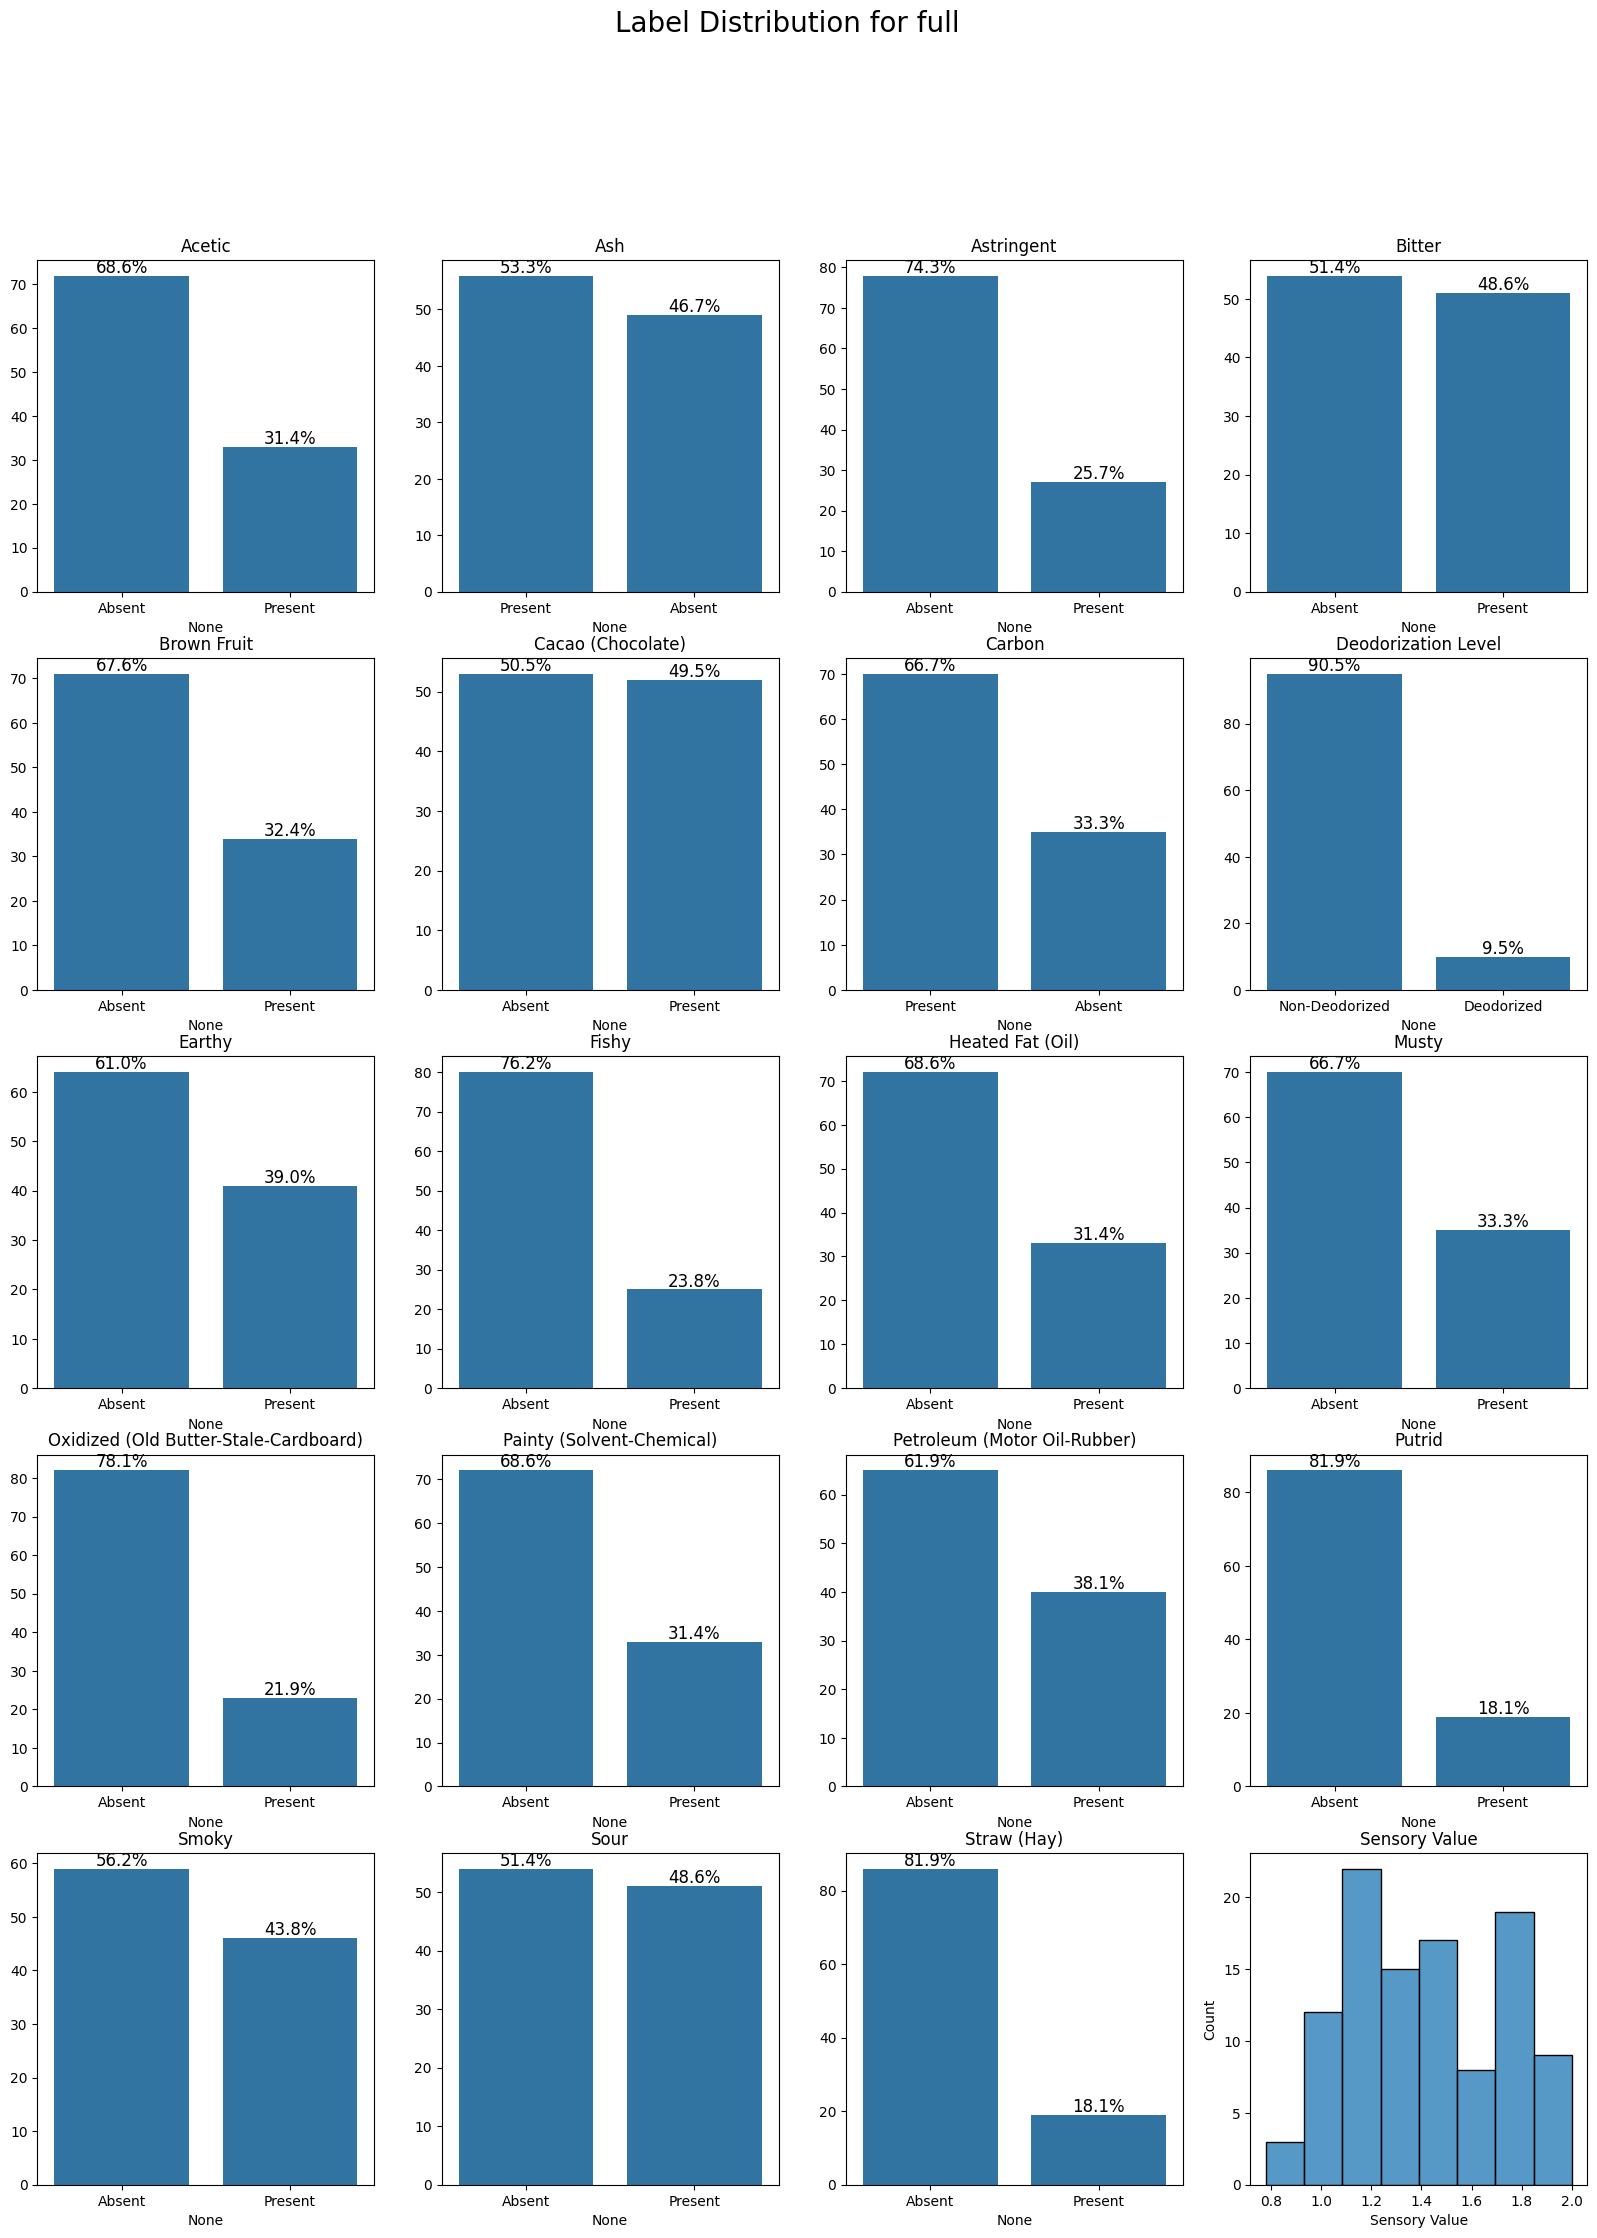

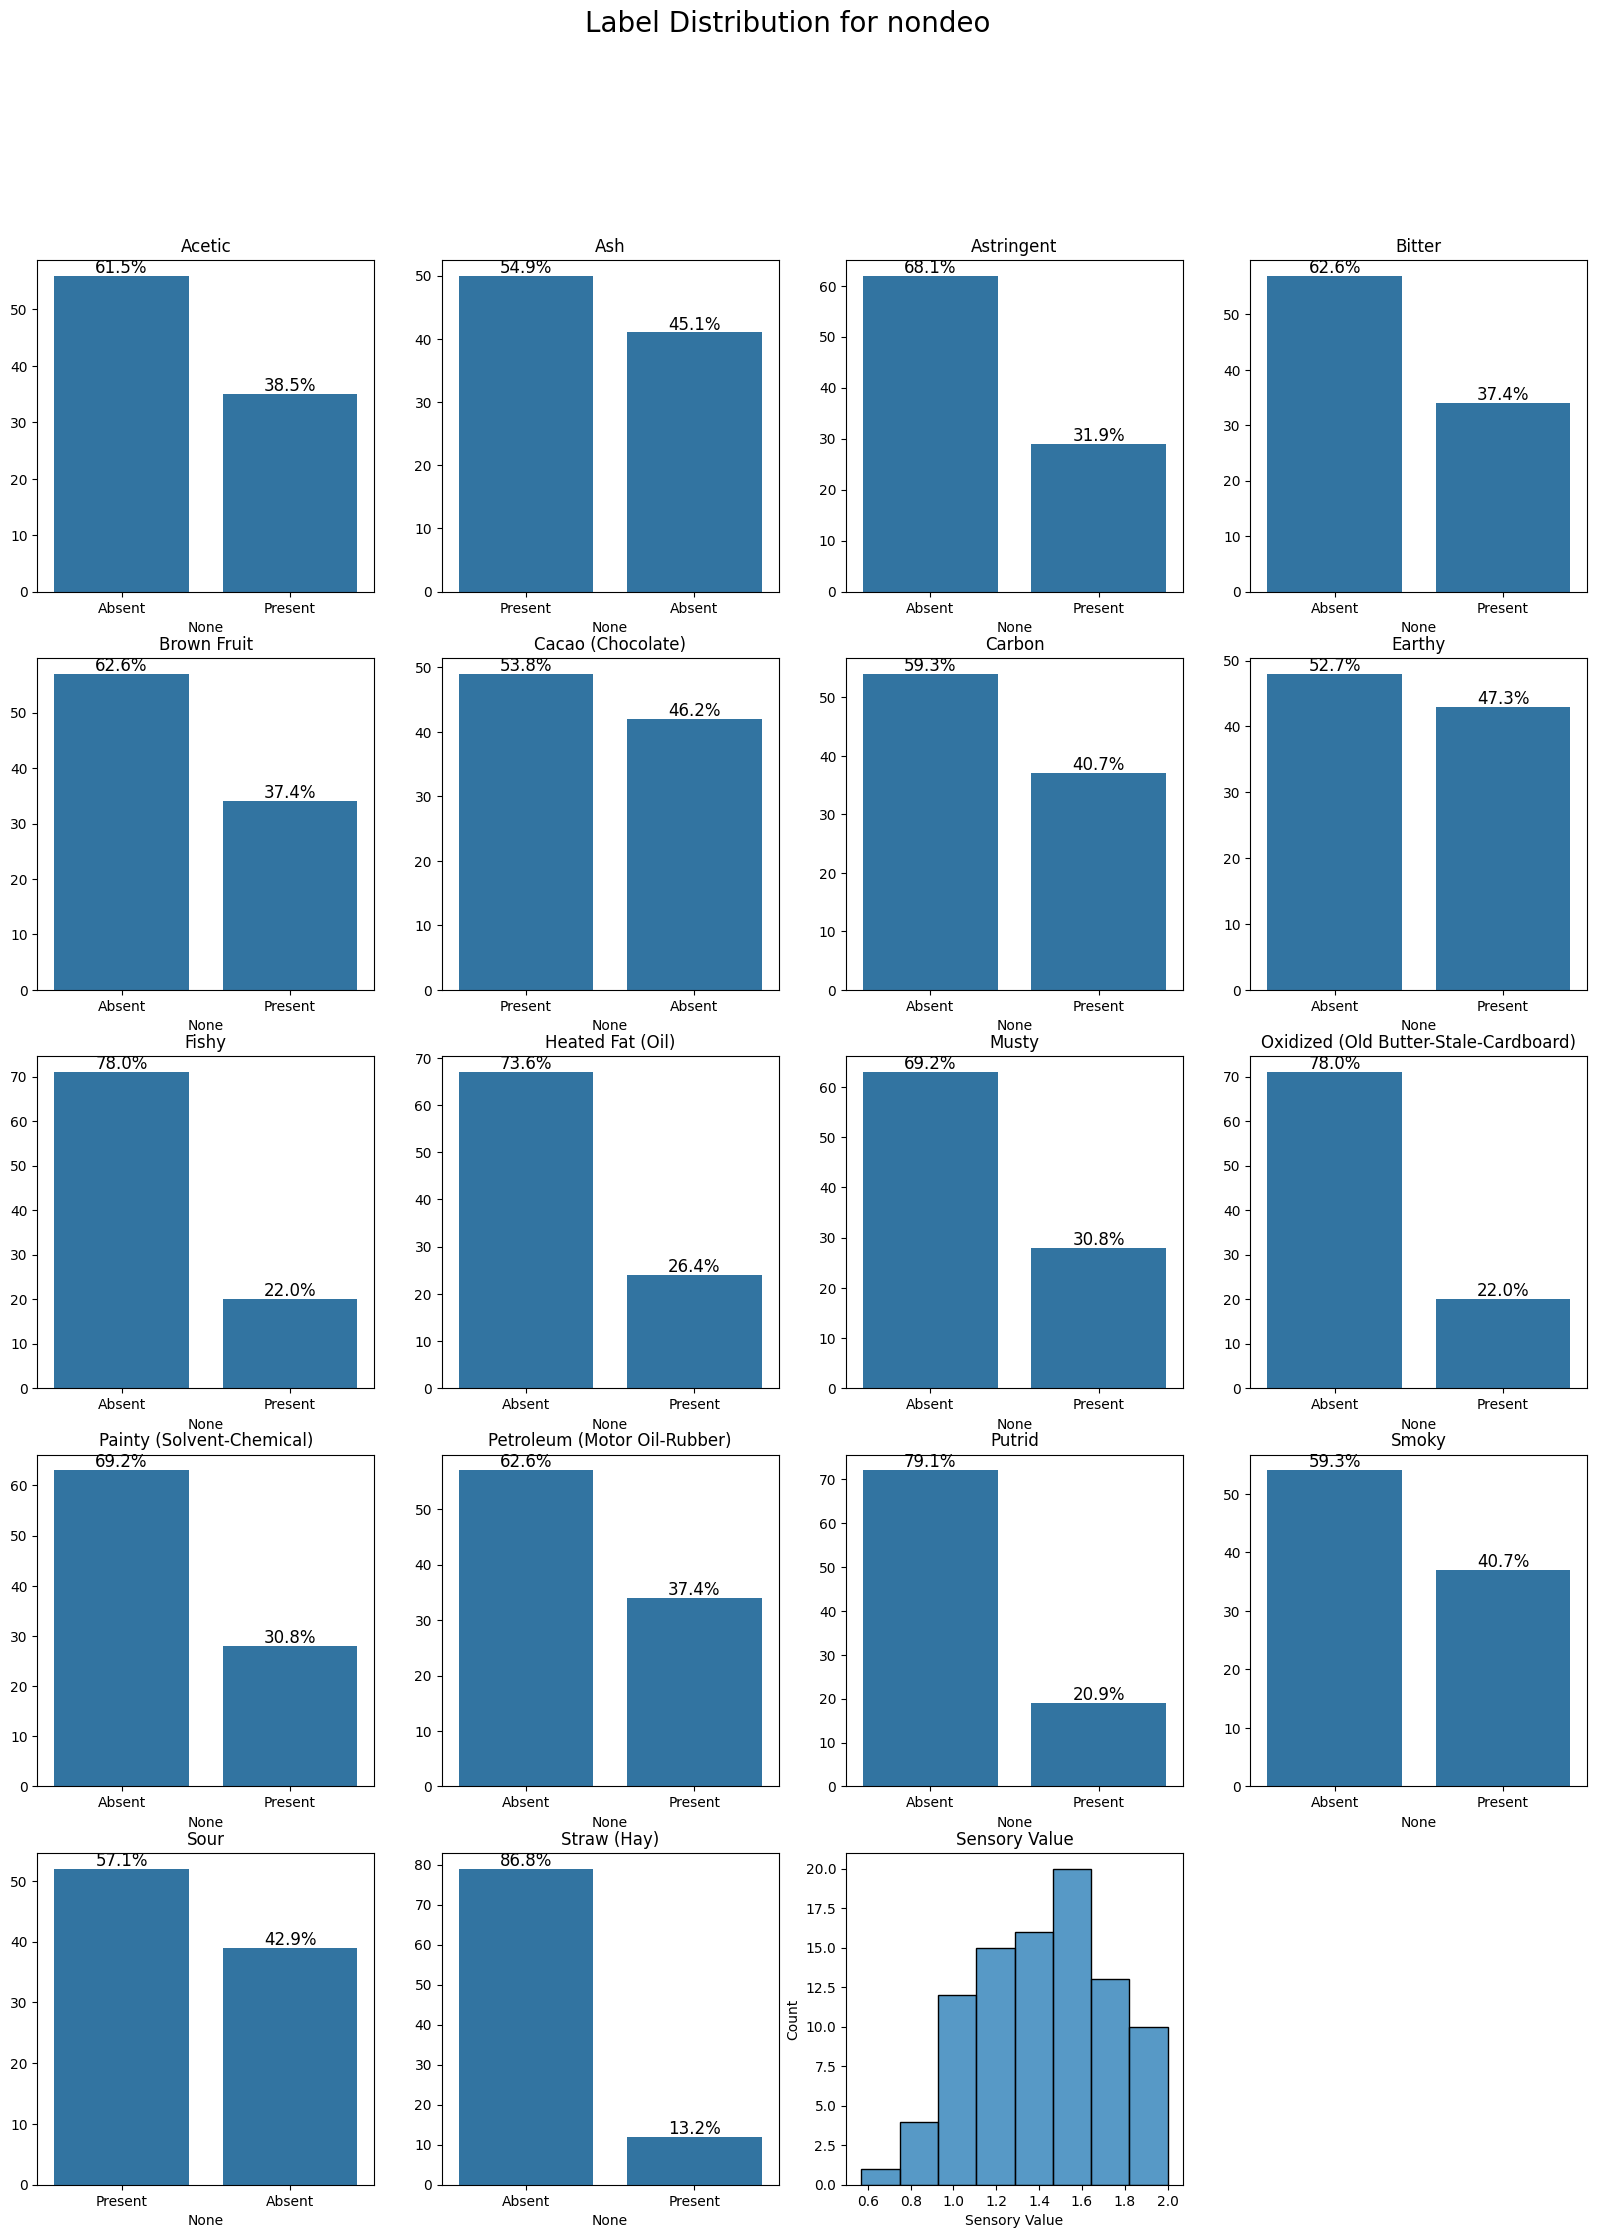

In [6]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')

    y_train_downsampled = datasets[dataset]['y_train_downsampled'].drop_duplicates()

    num_cols = len(y_train_downsampled.columns)
    rows = int(np.ceil(num_cols / 4))  # Calculate required rows dynamically
    fig, ax = plt.subplots(rows, 4, figsize=(20, 5 * rows))
    fig.suptitle(f'Label Distribution for {dataset}\n\n', fontsize=20)

    # Flatten ax to avoid indexing issues when rows < 4
    ax = ax.flatten()

    for i, col in enumerate(y_train_downsampled.columns):
        if y_train_downsampled[col].dtype == 'float64':
            sns.histplot(y_train_downsampled[col], ax=ax[i])
            ax[i].set_title(f'{col}')
        else:
            value_counts = y_train_downsampled[col].value_counts()
            total = value_counts.sum()  # Get total count for percentage
            sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax[i])
            ax[i].set_title(f'{col}')
            
            # Add percentage labels
            for j, value in enumerate(value_counts.values):
                percentage = (value / total) * 100
                ax[i].text(j, value + 0.01 * max(value_counts.values), f'{percentage:.1f}%', ha='center', fontsize=12, color='black')


    # Hide any unused subplots
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])